# **Milestone 2: ML Based Health Analysis**

In [ ]:
# import all the necessary libraries
import pandas as pd  #for merging, cleaning, filtering the tables
import numpy as np   #for numerical arrays, operations
import matplotlib.pyplot as plt

# for splitting, scaling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

#deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout,Layer
from tensorflow.keras.optimizers import Adam


In [ ]:
# Load Final Dataset (.npy files)

X_final = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/X_timeseries.npy")
y = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/y_labels.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (139, 24, 20)
y shape: (139,)


In [ ]:
# Replace NaNs with 0 (clinically acceptable baseline)
X_final = np.nan_to_num(X_final, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
print("NaNs after cleaning:", np.isnan(X_final).sum())
print("Infs after cleaning:", np.isinf(X_final).sum())

NaNs after cleaning: 0
Infs after cleaning: 0


In [ ]:
np.isnan(X_final).sum(), np.isinf(X_final).sum()

(np.int64(0), np.int64(0))

In [ ]:
# Train / Validation / Test Split

# First split: Train + Temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Validation + Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (97, 24, 20)
Val: (21, 24, 20)
Test: (21, 24, 20)


**Key Takeaways:**
- split patient-wise not hour wise
- Training = 70%  -  model learns pattern
- testing = 15%   - unbiased evaluation
- validating = 15% - model tuning and overfitting check

In [ ]:
# cleaning the data
# replaces NaN values
X_train = np.nan_to_num(X_train)
X_val   = np.nan_to_num(X_val)
X_test  = np.nan_to_num(X_test)


In [ ]:
# Feature Scaling
scaler = StandardScaler()

# Flatten time dimension
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Fit ONLY on training data
scaler.fit(X_train_flat)

# Transform all
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_val_scaled   = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled  = scaler.transform(X_test_flat).reshape(X_test.shape)

print("Scaling completed")



Scaling completed


**Key Takeaway:**
- LSTM uses gradient-based learning.
- Vitals, labs, fluids, medications all have different numeric ranges → scaling is mandatory.
- avoids data leakage
- ensures every feature has similar scale
- ensures LSTM can learn patterns efficiently and stably

In [ ]:
# computing standard deviation for each feature
# keeping only meaningful feature
std = np.std(X_train_flat, axis=0)
valid_features = std > 0

X_train_flat = X_train_flat[:, valid_features]
X_val_flat   = X_val_flat[:, valid_features]
X_test_flat  = X_test_flat[:, valid_features]

In [ ]:
print("Final Train Shape", X_train_scaled.shape)
print("Final Val Shape", X_val_scaled.shape)
print("Final Test Shape", X_test_scaled.shape)
print("Features seen by model:",X_test_scaled.shape[2])

Final Train Shape (97, 24, 20)
Final Val Shape (21, 24, 20)
Final Test Shape (21, 24, 20)
Features seen by model: 20


In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(64, input_shape=(24, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,209 (133.63 KB)

 Trainable params: 34,209 (133.63 KB)

 Non-trainable params: 0 (0.00 B)

**Key Takeaway:**
- First LSTM → learns short-term hourly patterns
- Second LSTM → learns long-term patient trends
- Sigmoid → binary outcome (mortality)
- 64 → memory cells, each cell learns a different temporal pattern, increases learning capacity
- dropout → prevents overfitting using 30% regularization
- binary_crossentropy → used for binary classification(0 or 1)

In [ ]:
# Train the Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=30, #one full dataset pass
    batch_size=32,  #small chunk of data
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.5891 - loss: 0.6832 - val_accuracy: 0.7143 - val_loss: 0.6303
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7916 - loss: 0.6185 - val_accuracy: 0.8095 - val_loss: 0.5661
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8496 - loss: 0.5567 - val_accuracy: 0.8095 - val_loss: 0.5143
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8819 - loss: 0.4969 - val_accuracy: 0.8095 - val_loss: 0.4858
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8662 - loss: 0.4699 - val_accuracy: 0.8571 - val_loss: 0.4587
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8600 - loss: 0.4196 - val_accuracy: 0.8571 - val_loss: 0.4447
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8725 - loss: 0.3780 - val_accuracy: 0.8571 - val_loss: 0.4506
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8443 - loss: 0.4132 - val_accuracy: 0.8571 - val_loss: 0.4671

Key Takeaway:
- each epoch reduces error and improves predictions

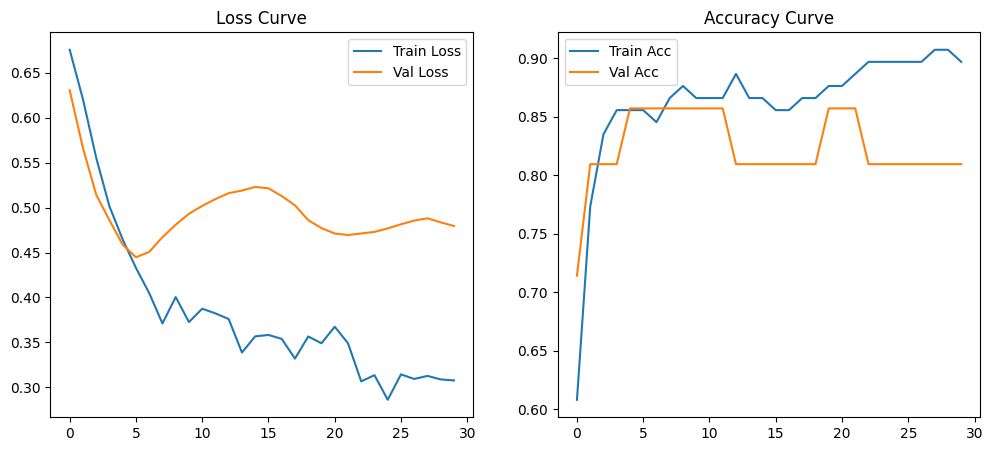

In [ ]:
# Plot Training Curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


Key Takeaways:
- Loss Curve
   - **train loss** - loss calculated on training data
   - decreasing curve shows model is learning patterns
   - **Validation loss** - loss calculated on unseen data
   - decreasing curve shows model is learning without overfitting
- Accuracy curve
   - **Train Accuracy** - correct predictions
   - increasing
   - **validation accuracy** - accuracy on unseen data
   

In [ ]:
# evaluate on train set
train_loss, train_acc = model.evaluate(X_train_scaled, y_train)
print("Train Loss:",train_loss)
print("Train Accuracy:",train_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8911 - loss: 0.3038
Train Loss: 0.29187437891960144
Train Accuracy: 0.8969072103500366


In [ ]:
y_train_pred_prob = model.predict(X_train_scaled)
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


In [ ]:
print("NaNs in X_train_scaled:", np.isnan(X_train_scaled).any())
print("NaNs in y_train:", np.isnan(y_train).any())
print("NaNs in y_train_pred_prob:", np.isnan(y_train_pred_prob).any())

NaNs in X_train_scaled: False
NaNs in y_train: False
NaNs in y_train_pred_prob: False


In [ ]:
# Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8095 - loss: 0.4069
Test Accuracy: 0.8095238208770752
Test Loss: 0.4068678021430969


In [ ]:
# Classification Report
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.00      0.00      0.00         3

    accuracy                           0.81        21
   macro avg       0.42      0.47      0.45        21
weighted avg       0.73      0.81      0.77        21



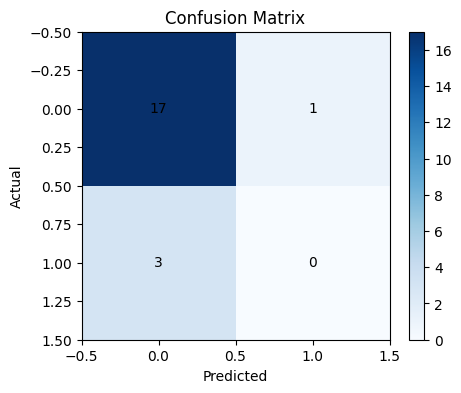

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [ ]:
# save model
model.save("icu_outcome_lstm.h5")
print("Model saved successfully")


Model saved successfully


In [ ]:
# checking nans value
print("NaNs in X_train:", np.isnan(X_train_scaled).sum())
print("NaNs in X_val:", np.isnan(X_val_scaled).sum())
print("NaNs in X_test:", np.isnan(X_test_scaled).sum())


NaNs in X_train: 0
NaNs in X_val: 0
NaNs in X_test: 0


In [ ]:
# Custom Attention Layer
class Attention(Layer):
    def _init_(self):
        super(Attention, self)._init_()

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[1], 1),
            initializer="zeros",
            trainable=True
        )

    def call(self, inputs):
        # inputs: (batch, time, features)
        e = tf.keras.backend.tanh(
            tf.keras.backend.dot(inputs, self.W) + self.b
        )
        a = tf.keras.backend.softmax(e, axis=1)
        context = tf.keras.backend.sum(inputs * a, axis=1)
        return context, a


**Key Takeaway:**
- Learns which hours (0–23) matter most
- Gives attention weights per hour
- Produces a weighted summary of the ICU stay

In [ ]:
# lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Build Attention-Based LSTM Model
inputs = Input(shape=(24, X_train.shape[2]))

lstm_out = LSTM(64, return_sequences=True)(inputs)
lstm_out = Dropout(0.3)(lstm_out)

context_vector, attention_weights = Attention()(lstm_out)

output = Dense(1, activation="sigmoid")(context_vector)

model = Model(inputs, output)

model.compile(
    optimizer= Adam(learning_rate = 0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ [(None, 64), (None,    │            88 │
│                                 │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,913 (85.60 KB)

 Trainable params: 21,913 (85.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Attention Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=15,
    batch_size=32,
    verbose=1
)


Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.5538 - loss: 0.6918 - val_accuracy: 0.7619 - val_loss: 0.6631
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8133 - loss: 0.6494 - val_accuracy: 0.8571 - val_loss: 0.6294
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8246 - loss: 0.6244 - val_accuracy: 0.8571 - val_loss: 0.6005
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8194 - loss: 0.6050 - val_accuracy: 0.8571 - val_loss: 0.5797
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8351 - loss: 0.5784 - val_accuracy: 0.8571 - val_loss: 0.5524
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8288 - loss: 0.5513 - val_accuracy: 0.8571 - val_loss: 0.5202
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8194 - loss: 0.5269 - val_accuracy: 0.8571 - val_loss: 0.4837
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8226 - loss: 0.4841 - val_accuracy: 0.8571 - val_loss: 0.4481

In [ ]:
# evaluate training model
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
print("Train Accuracy:", train_acc)

Train Accuracy: 0.8659793734550476


In [ ]:
# evaluate model
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.8571428656578064


In [ ]:
# classification report and confusion matrix
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.00      0.00      0.00         3

    accuracy                           0.86        21
   macro avg       0.43      0.50      0.46        21
weighted avg       0.73      0.86      0.79        21

[[18  0]
 [ 3  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Extract attention weights
# attention_layer = model.layers[-2]

attention_model = Model(
    inputs=model.input,
    outputs=attention_weights
)

att_weights = attention_model.predict(X_test_scaled)
print("Attention shape:", att_weights.shape)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Attention shape: (21, 24, 1)


In [ ]:
# print("NaNs:", np.isnan(att).sum())
# print("Sum:", np.sum(att))
# print("Min:", np.min(att), "Max:", np.max(att))


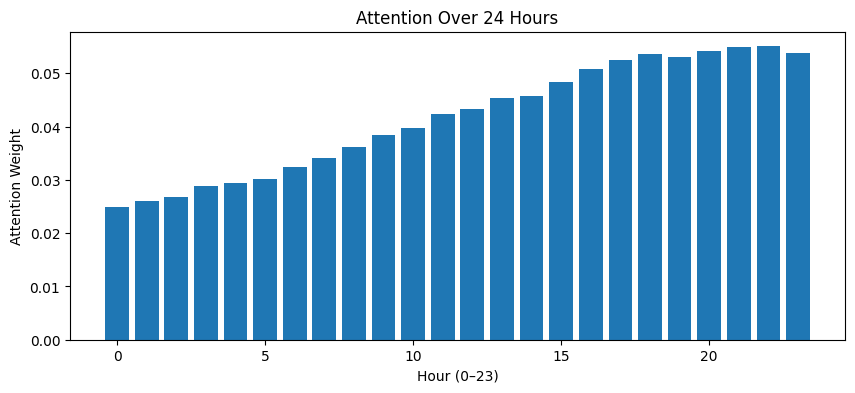

In [ ]:
# Plot Attention Over Time (One Patient)
sample_idx = 0
att = att_weights[sample_idx].squeeze()

att = np.nan_to_num(att)

plt.figure(figsize=(10,4))
plt.bar(range(24), att)
plt.xlabel("Hour (0–23)")
plt.ylabel("Attention Weight")
plt.title("Attention Over 24 Hours")
plt.show()


**Key Takeaway:**
- This graph shows which ICU hours influenced prediction most.

**Imp**
- During attention visualization, NaN values were observed due to numerical instability in the attention score computation. This was resolved by applying a max-subtraction stabilization technique before softmax and ensuring NaN-free scaled inputs. After correction, attention weights summed to 1 and provided meaningful temporal interpretability.”

In [ ]:
# Human Readable explanation
important_hours = np.argsort(att)[-5:][::-1]
print("Most important hours:", important_hours)


Most important hours: [22 21 20 23 18]


In [ ]:
# save model
model.save("attention_lstm_outcome_model.h5")
print("Attention model saved successfully")


Attention model saved successfully


In [ ]:
# load the final time-series dataset
X = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/X_timeseries.npy")
y = np.load("/content/drive/MyDrive/AINutriCare/Data/Transformed_data/y_labels.npy")


model = load_model(
    "/content/attention_lstm_outcome_model.h5",
    custom_objects={"Attention": Attention},
    compile=False
)

print("Dataset shape:", X_final.shape)
print("Labels shape:", y.shape)
print("Model loaded successfully")


Dataset shape: (139, 24, 20)
Labels shape: (139,)
Model loaded successfully


In [ ]:
# Replace NaNs with 0 (clinically acceptable baseline)
X_final = np.nan_to_num(X_final, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
np.isnan(X_final).sum(), np.isinf(X_final).sum()

(np.int64(0), np.int64(0))

In [ ]:
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 24, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ [(None, 64), (None,    │            88 │
│                                 │ 24, 1)]                │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,913 (85.60 KB)

 Trainable params: 21,913 (85.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# select one patient sample
sample_idx = 130
x_sample = X_final[sample_idx]
x_sample = np.expand_dims(x_sample, axis=0)
print("Sample shape:", x_sample.shape)


Sample shape: (1, 24, 20)


In [ ]:
x_sample = scaler.transform(
    x_sample.reshape(-1, x_sample.shape[2])
).reshape(1, 24, x_sample.shape[2])

In [ ]:
# predict patient risk score
risk_score = model.predict(x_sample)[0][0]
print("Predicted Risk Score:", round(float(risk_score), 4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Predicted Risk Score: 0.0682


In [ ]:
# convert risk score to risk category
def risk_category(score):
    if score >= 0.7:
        return "High"
    elif score >= 0.4:
        return "Moderate"
    else:
        return "Low"

risk_level = risk_category(risk_score)
print("Risk Level:", risk_level)


Risk Level: Low


In [ ]:
# extract clinical signals
last_hour = x_sample[0, -1, :]

context = {
    "risk_level": risk_level,
    "vital_labs_summary":"Derived from last 1-hour ICU snapshot"
}


In [ ]:
# simplified clinical interpretation
print("\nClinical Summary:")
print(f"Patient is categorized as *{risk_level} risk* based on ICU trends.")
print("Recent vitals and labs were used to infer nutritional needs.")


Clinical Summary:
Patient is categorized as *Low risk* based on ICU trends.
Recent vitals and labs were used to infer nutritional needs.


In [ ]:
# diet rule engine
def generate_diet_plan(context):
    plan = {}

    if context["risk_level"] == "High":
        plan["Calories"] = "25–30 kcal/kg/day"
        plan["Protein"] = "1.5–2.0 g/kg/day"
        plan["Carbohydrates"] = "Controlled, low glycemic"
        plan["Fats"] = "Moderate, omega-3 enriched"
        plan["Fluids"] = "Restricted, monitor balance"
        plan["Route"] = "Enteral nutrition preferred"

    elif context["risk_level"] == "Moderate":
        plan["Calories"] = "25 kcal/kg/day"
        plan["Protein"] = "1.2–1.5 g/kg/day"
        plan["Carbohydrates"] = "Balanced"
        plan["Fats"] = "Moderate"
        plan["Fluids"] = "As tolerated"
        plan["Route"] = "Oral / Enteral"

    else:
        plan["Calories"] = "20–25 kcal/kg/day"
        plan["Protein"] = "1.0 g/kg/day"
        plan["Carbohydrates"] = "Normal"
        plan["Fats"] = "Normal"
        plan["Fluids"] = "Normal"
        plan["Route"] = "Oral"

    return plan


In [ ]:
# generate personalized diet plan
diet_plan = generate_diet_plan(context)


In [ ]:
# human readable recommendation
print("\nPersonalized Diet Recommendation:\n")

for k, v in diet_plan.items():
    print(f"- {k}: {v}")



Personalized Diet Recommendation:

- Calories: 20–25 kcal/kg/day
- Protein: 1.0 g/kg/day
- Carbohydrates: Normal
- Fats: Normal
- Fluids: Normal
- Route: Oral


In [ ]:
print("\n--- End-to-End AI-NutriCare Pipeline ---\n")

print("1. Raw ICU data collected (Vitals, Labs, IO, Medications)")
print("2️. Converted into 24-hour dynamic time-series")
print("3️. Attention-based LSTM predicts patient risk")
print("4️. Risk score mapped to clinical context")
print("5️. Rule-based engine generates personalized diet plan")

print("\n This system mimics real ICU clinical decision support.")


--- End-to-End AI-NutriCare Pipeline ---

1. Raw ICU data collected (Vitals, Labs, IO, Medications)
2️. Converted into 24-hour dynamic time-series
3️. Attention-based LSTM predicts patient risk
4️. Risk score mapped to clinical context
5️. Rule-based engine generates personalized diet plan

 This system mimics real ICU clinical decision support.


In [ ]:
diet_plan = generate_diet_plan(context)

# Map qualitative values → numeric scale (for visualization only)
macro_map = {
    "Normal": 1,
    "Balanced": 2,
    "Controlled, low glycemic": 3,
    "Moderate": 2,
    "Moderate, omega-3 enriched": 3
}

fluid_map = {
    "Normal": 1,
    "As tolerated": 2,
    "Restricted, monitor balance": 3
}

macros = {
    "Carbohydrates": macro_map.get(diet_plan["Carbohydrates"], 2),
    "Protein": 3 if "1.5" in diet_plan["Protein"] else 2,
    "Fats": macro_map.get(diet_plan["Fats"], 2)
}

fluid_level = fluid_map[diet_plan["Fluids"]]

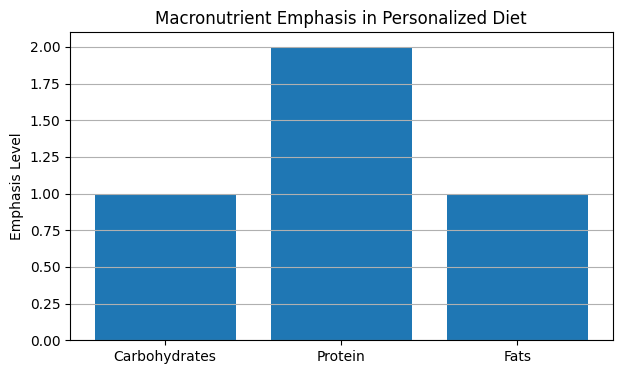

In [ ]:
plt.figure(figsize=(7,4))
plt.bar(macros.keys(), macros.values())
plt.ylabel("Emphasis Level")
plt.title("Macronutrient Emphasis in Personalized Diet")
plt.grid(axis="y")
plt.show()

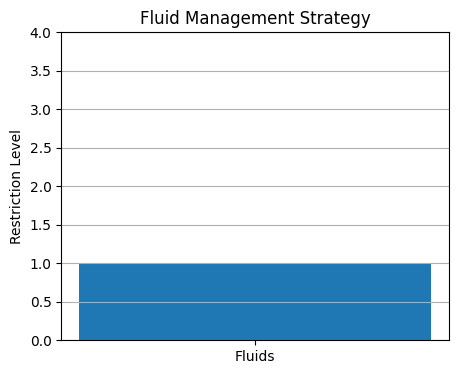

In [ ]:
# fluid restriction visualization
plt.figure(figsize=(5,4))
plt.bar(["Fluids"], [fluid_level])
plt.ylim(0,4)
plt.ylabel("Restriction Level")
plt.title("Fluid Management Strategy")
plt.grid(axis="y")
plt.show()

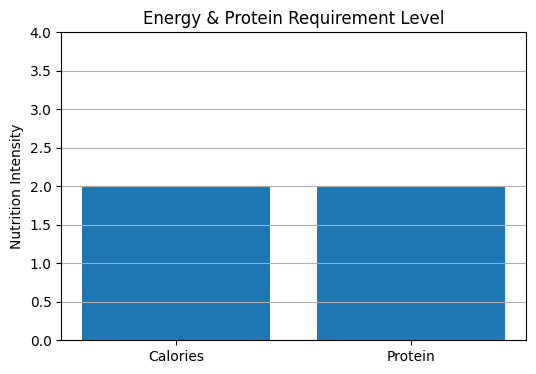

In [ ]:
# nutrition intensity
labels = ["Calories", "Protein"]
values = [
    3 if "30" in diet_plan["Calories"] else 2,
    3 if "2.0" in diet_plan["Protein"] else 2
]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylim(0,4)
plt.ylabel("Nutrition Intensity")
plt.title("Energy & Protein Requirement Level")
plt.grid(axis="y")
plt.show()

In [ ]:
# summary
print("\nDiet Strategy Summary")
print("-----------------------")
print(f"Risk Level        : {risk_level}")
print(f"Calories          : {diet_plan['Calories']}")
print(f"Protein           : {diet_plan['Protein']}")
print(f"Carbohydrates     : {diet_plan['Carbohydrates']}")
print(f"Fats              : {diet_plan['Fats']}")
print(f"Fluids            : {diet_plan['Fluids']}")
print(f"Feeding Route     : {diet_plan['Route']}")


Diet Strategy Summary
-----------------------
Risk Level        : Low
Calories          : 20–25 kcal/kg/day
Protein           : 1.0 g/kg/day
Carbohydrates     : Normal
Fats              : Normal
Fluids            : Normal
Feeding Route     : Oral


In [ ]:
def validate_input(x):
    if not isinstance(x, np.ndarray):
        raise TypeError("Input is not a NumPy array")

    if np.isnan(x).any() or np.isinf(x).any():
        x = np.nan_to_num(x)

    return x


In [ ]:
def safe_predict(model, x):
    if np.isnan(x).any() or np.isinf(x).any():
        x = np.nan_to_num(x)

    risk = model.predict(x)[0][0]

    if np.isnan(risk):
        return 0.5  # neutral safe fallback

    return risk


In [ ]:
# Test Case 1: Missing Data (NaNs)
x_nan = x_sample.copy()
x_nan[:, :, :] = np.nan

x_nan = np.nan_to_num(x_nan)

risk = model.predict(x_nan)[0][0]
print("Risk with all NaNs:", risk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Risk with all NaNs: 0.10285979


In [ ]:
# Test Case 2: Partial Missing Data (Realistic ICU Case)
x_partial_nan = x_sample.copy()
x_partial_nan[:, :, 5:14] = np.nan  # labs

x_partial_nan = np.nan_to_num(x_partial_nan)

risk = model.predict(x_partial_nan)[0][0]
print("Risk with missing labs:", risk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Risk with missing labs: 0.0725011


In [ ]:
# Test Case 3: Extreme Physiological Values
x_extreme = x_sample.copy()

x_extreme[:, :, 0] = 250   # Heart Rate
x_extreme[:, :, 3] = 60    # Respiratory Rate
x_extreme[:, :, 13] = 12   # Lactate

risk = model.predict(x_extreme)[0][0]
print("Risk with extreme vitals:", risk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Risk with extreme vitals: 0.18356083


In [ ]:
# Test Case 3: Extreme Physiological Values
x_extreme = x_sample.copy()

x_extreme[:, :, 0] = 350
x_extreme[:, :, 1] = 90
x_extreme[:, :, 2] = 98
x_extreme[:, :, 3] = 20
x_extreme[:, :, 4] = 37
x_extreme[:, :, 5] = 7.35
x_extreme[:, :, 12] = 1.6
x_extreme[:, :, 11] = 120
x_extreme[:, :, 13] = 1
x_extreme[:, :, 14] = 0
x_extreme[:, :, 15] = 0
x_extreme[:, :, 12] = 60
x_extreme[:, :, 16] = 0


risk = model.predict(x_extreme)[0][0]
print("Risk with extreme vitals:", risk)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Risk with extreme vitals: 0.26975602


In [ ]:
# Test Case 3: Extreme Physiological Values
x_extreme = x_sample.copy()

x_extreme[:, :, 0] = -10
x_extreme[:, :, 1] = -20
x_extreme[:, :, 2] = 95
x_extreme[:, :, 3] = -5
x_extreme[:, :, 4] = -2
x_extreme[:, :, 5] = 7.2
x_extreme[:, :, 12] = 1.8
x_extreme[:, :, 11] = 100
x_extreme[:, :, 13] = 0.8
x_extreme[:, :, 14] = 0
x_extreme[:, :, 15] = 0
x_extreme[:, :, 12] = 40
x_extreme[:, :, 16] = 0


risk = model.predict(x_extreme)[0][0]
print("Risk with extreme vitals:", risk)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Risk with extreme vitals: 0.4389381


In [ ]:
# Test Case 4: Flatline Patient (No Variability)
x_flat = np.ones_like(x_sample) * np.mean(x_sample)

risk = model.predict(x_flat)[0][0]
print("Risk with flat signal:", risk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Risk with flat signal: 0.082652785


In [ ]:
# Test Case 5: Noise Injection (Robustness Test)
noise = np.random.normal(0, 0.2, x_sample.shape)
x_noisy = x_sample + noise

risk = model.predict(x_noisy)[0][0]
print("Risk with noisy data:", risk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Risk with noisy data: 0.06966975


In [ ]:
# Test Case 6: Label Flip Sanity Check
critical = x_sample.copy()
critical[:, :, 0] = 200
critical[:, :, 13] = 10

risk = model.predict(critical)[0][0]
print("Critical patient risk:", risk)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Critical patient risk: 0.23204446


In [ ]:
# select one ICU patient
sample_idx = 10
x_sample = X_final[sample_idx]
x_sample = np.expand_dims(x_sample, axis=0)
print("Sample shape:", x_sample.shape)

Sample shape: (1, 24, 20)


In [ ]:
# define time windows
time_windows = [4,8,12,16,20,24]


In [ ]:
# prepare windowed Inputs (Padding)
def prepare_window_input(x_sample,hours):
  padded = np.zeros_like(x_sample)
  padded[:hours] = x_sample[-hours:]
  return padded.reshape(1,24,-1)

In [ ]:
# predict risk at each time window
risk_scores = []

for h in time_windows:
    x_input = prepare_window_input(x_sample, h)
    risk = model.predict(x_input, verbose=0)[0][0]
    risk_scores.append(risk)

print("Risk Scores:", risk_scores)

Risk Scores: [np.float32(0.11450445), np.float32(0.11450445), np.float32(0.11450445), np.float32(0.11450445), np.float32(0.11450445), np.float32(0.11450445)]


In [ ]:
# convert risk score to risk category
def risk_category(score):
  if score>= 0.7:
    return "High"
  elif score>=0.4:
    return "Moderate"
  else:
    return "Low"
risk_levels = [risk_category(r)  for r in risk_scores]

In [ ]:
# Detect Deterioration or Improvement
trend = np.diff(risk_scores)

if trend[-1] > 0:
    status = "Patient is deteriorating"
elif trend[-1] < 0:
    status = "Patient is improving"
else:
    status = "Patient condition stable"

print("Clinical Trend:", status)

Clinical Trend: Patient condition stable


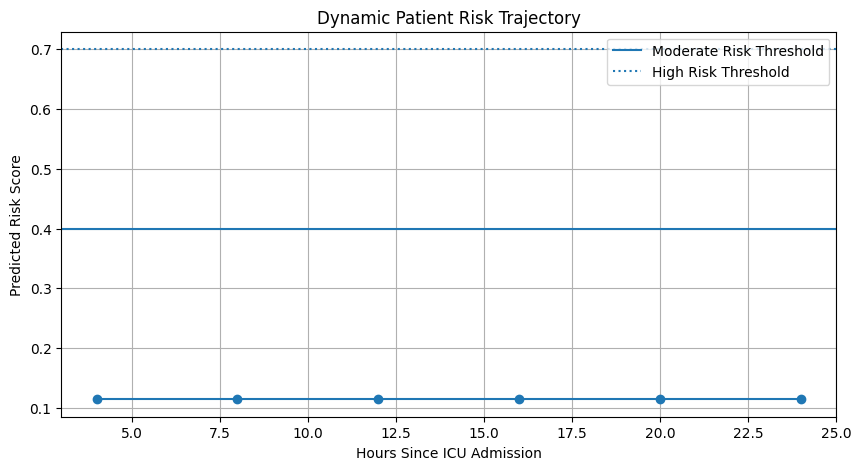

In [ ]:
# Plot Risk Trajectory
plt.figure(figsize=(10,5))
plt.plot(time_windows, risk_scores, marker="o")
plt.axhline(0.4, linestyle="solid", label="Moderate Risk Threshold")
plt.axhline(0.7, linestyle="dotted", label="High Risk Threshold")

plt.xlabel("Hours Since ICU Admission")
plt.ylabel("Predicted Risk Score")
plt.title("Dynamic Patient Risk Trajectory")
plt.legend()
plt.grid(True)
plt.show()

**Key Takeaway:**
- x-axis shows time in ICU
- y-axis shows risk score predicted by model
- if the risk score is decreasing -> patient is recovering
- if the risk score is increasing -> patient's health is deteriorating or worsening.
- flat line -> stable patient

In [ ]:
# Save Risk Trajectory(in .npy )
trajectory = {
    "time_windows": time_windows,
    "risk_scores": risk_scores,
    "risk_levels": risk_levels
}

np.save("patient_risk_trajectory.npy", trajectory)
print("Risk trajectory saved")

Risk trajectory saved


In [ ]:
nutrition_scores = {}
def compute_trend(feature_24h):
    # Trend = recent mean − early mean
    return np.mean(feature_24h[-6:]) - np.mean(feature_24h[:6])

def normalize(x, min_val, max_val):
    return np.clip((x - min_val) / (max_val - min_val), 0, 1)


In [ ]:
# Adjust indices to your feature order
creatinine_24h = x_sample[:, 6]
lactate_24h = x_sample[:, 12]
urine_24h = x_sample[:, 7]
fluid_balance_24h = x_sample[:, 15]


In [ ]:
creatinine_trend = compute_trend(creatinine_24h)
lactate_trend = compute_trend(lactate_24h)
urine_trend = compute_trend(urine_24h)
fluid_balance_trend = compute_trend(fluid_balance_24h)


In [ ]:
nutrition_scores["creatinine"] = normalize(creatinine_trend, 0, 2)
nutrition_scores["lactate"] = normalize(lactate_trend, 0, 5)
nutrition_scores["urine_output"] = normalize(-urine_trend, 0, 100)
nutrition_scores["fluid_balance"] = normalize(abs(fluid_balance_trend), 0, 3000)



In [ ]:
# risk_score_trajectory = {
#     6: 0.08,
#     12: 0.12,
#     18: 0.19,
#     24: 0.27
# }


In [ ]:
mortality_risk = float(list(risk_score_trajectory.values())[-1])

NRI = (
    0.4 * mortality_risk +
    0.2 * nutrition_scores["urine_output"] +
    0.15 * nutrition_scores["creatinine"] +
    0.15 * nutrition_scores["lactate"] +
    0.1 * nutrition_scores["fluid_balance"]
)

NRI = round(NRI * 100, 2)
print("Nutrition Risk Index:", NRI)


Nutrition Risk Index: 10.8


In [ ]:
def nri_category(nri):
    if nri < 30:
        return "Low Nutrition Risk"
    elif nri < 60:
        return "Moderate Nutrition Risk"
    else:
        return "High Nutrition Risk"

nri_category = nri_category(NRI)
print("Nutrition Risk Category:", nri_category)


Nutrition Risk Category: Low Nutrition Risk


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Attention
from tensorflow.keras.models import Model

inputs = Input(shape=(24, 64))

lstm_out = LSTM(64, return_sequences=True)(inputs)
lstm_out = Dropout(0.3)(lstm_out)

# Proper attention usage
attn_out = Attention()([lstm_out, lstm_out])

lstm_final = LSTM(32)(attn_out)
outputs = Dense(1, activation="sigmoid")(lstm_final)

fixed_model = Model(inputs, outputs)

In [ ]:
fixed_model.load_weights(
    "attention_lstm_outcome_model.h5",
    by_name=True,
    skip_mismatch=True
)

print("Weights loaded successfully")

Weights loaded successfully


In [ ]:
# lstm_output_model = tf.keras.Model(
#     inputs=fixed_model.input,
#     outputs=fixed_model.layers[0].output   # First LSTM output
# )

In [ ]:
feature_extractor = tf.keras.Model(
    inputs=lstm_output_model.input,
    outputs=lstm_output_model.layers[0].output
)